In [1]:
#imports
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import copy

from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

import seaborn as sns

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MEDMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/
The number of classes is: 2 
 The number of channels is 1.
The class_names are {'0': 'normal', '1': 'pneumonia'}
{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'task': 'binary-class', 'label': {'0': 'normal', '1': 'pneumonia'}, 'n_channels': 1, 'n_samples': {'train': 4708, 'val': 524, 'test': 624}, 'license': 'CC BY 4.0'}
Using downloaded and verified file: C:\Users\Theodora\.medmnist\

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


[631 391 504]


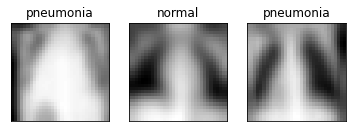

In [2]:
from dataset import train_dataset, test_dataset, train_loader, test_loader, task, n_channels, n_classes

In [3]:
print(len(test_dataset))

624


In [4]:
class MyDropout(nn.Module):                                                        #custom Dropout layer for saving the parameters, to be used in LRP
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        self.seed = 0
    
    def forward(self, input, freeze = False):
        if not self.training:                                                      # if model.eval(), don't apply dropout
            return input

        if not freeze:                                                             # if freeze == False, generate new random seed
            q=np.random.randint(10000000, size = 1)[0]                             # if freeze == True , use random seed from previous run (used in LRP)
            self.seed = q
        
        torch.manual_seed(self.seed)   
        return torch.nn.functional.dropout2d(input, p=self.p)

class LeNet(nn.Module):
    def __init__(self, n_channels, n_classes, droprate=0.5):
        super(LeNet, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(n_channels, 24, 5))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('maxpool1', nn.MaxPool2d(2))
        self.model.add_module('conv2', nn.Conv2d(24, 48, kernel_size=5))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('dropout2', MyDropout())
        self.model.add_module('maxpool2', nn.MaxPool2d(2))
        self.model.add_module('flatten', nn.Flatten())
        self.model.add_module('dense3', nn.Linear(48*5*5, 240))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout3', MyDropout())
        self.model.add_module('final', nn.Linear(240, n_classes))
        
    def forward(self, x):
        return self.model(x)

model = LeNet(n_classes, n_channels)
# model.load_state_dict(torch.load('mnist_lenet.ckpt', map_location=torch.device('cpu')))                           #load model from file

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
# print(device)

In [5]:
model = LeNet(n_channels, n_classes)
model.load_state_dict(torch.load('../outputs/pneumonia_mnist_lenet_2.ckpt', map_location=torch.device('cpu')))                           #load model from file

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


In [6]:
# --------------------------------------------------------------
# LRP Epsilon rule
# --------------------------------------------------------------

# More information at http://www.heatmapping.org/tutorial/

def LRP_epsilon(image, class_id, model, dropout = True, verbose = False, device = 'cpu', epsilon = 1e-9):


    # image:        Original Image,
    # class_id:     Index of a true class,
    # model:        Neural Network,
    # dropout:      If set True -- run LRP-Epsilon on a sample from posterior, else run Standard LRP-Epsilon,
    # verbose:      If set True -- print top 3 output scores,
    # device:       Default device,
    # epsilon:      Value of epsilon,
   
    if not dropout:
        model.eval()
    else:
        model.train()
    model.to(device)

    X = image.view([1,1,32,32]).to(device)
    layers = list(model.modules())[2:]
    L = len(layers)


    A = [X]+[None]*L
    with torch.no_grad():
      for l in range(L): A[l+1] = layers[l].forward(A[l]).to(device)
    
    scores = np.array(A[-1].data.view(-1).cpu())
    ind = np.argsort(-scores) # sorts the output classes by max probability: array of 10 indices
    
    if verbose:
        for i in ind[:3]:
            print('New instance:')
            print('%20s (%3d): %6.3f'%(imgclasses[i][:20],i,scores[i]))

    T = A[-1].cpu().detach().numpy().tolist()[0]
    index = T.index(max(T))
    T = np.abs(np.array(T))*0
    T[index]=1
    #T = torch.FloatTensor((1.*(np.arange(2)==class_id).reshape(A[-1].shape))).to(device) # reform to one hot vector
    R = [None] * L + [(A[-1]*T)] # R is None*12 + A[-1], only the prob of the max prob, all other elements 0 value

    for l in range(0,L)[::-1]:
        A[l] = A[l].requires_grad_(True)
        rho = lambda p: p;                       incr = lambda z: z + epsilon

        if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)
        
        if isinstance(layers[l],torch.nn.Conv2d) or \
           isinstance(layers[l],torch.nn.AvgPool2d) or \
           isinstance(layers[l],torch.nn.Linear) or \
           isinstance(layers[l],torch.nn.Flatten):

            z = incr(newlayer(layers[l],rho).forward(A[l]))        # step 1
            s = (R[l+1]/z).data                                    # step 2
            (z*s).sum().backward(); c = A[l].grad                  # step 3
            R[l] = (A[l]*c).data                                   # step 4
            
        else:
            if not dropout:
              R[l] = R[l+1]
            else:
              if isinstance(layers[l],MyDropout):
                  incr = lambda z: z + epsilon
                  z = incr(layers[l].forward(A[l], freeze = True))       # step 1: we freeze random state so we can remember which neurons were dropped
                  s = (R[l+1]/z).data                                    # step 2
                  (z*s).sum().backward(); c = A[l].grad                  # step 3
                  R[l] = (A[l]*c).data                                   # step 4
              else:
                  R[l] = R[l+1]

    return R[0].data


# --------------------------------------------------------------
# Clone a layer and pass its parameters through the function g
# --------------------------------------------------------------

def newlayer(layer,g):

    layer = copy.deepcopy(layer)

    try: layer.weight = nn.Parameter(g(layer.weight))
    except AttributeError: pass

    try: layer.bias   = nn.Parameter(g(layer.bias))
    except AttributeError: pass

    return layer

# --------------------------------------------------------------
# Function for MinMax Normalisation of Relevances
# --------------------------------------------------------------

def normalise_relevance(relevance_matrix):
    a = relevance_matrix.min()
    b = relevance_matrix.max()
    
    if (a == 0.) & (b == 0.):
        return relevance_matrix
    if (a > 0.):
      return (relevance_matrix >0.)*relevance_matrix/b
    if (b < 0.):
      return - (relevance_matrix <=0.)*relevance_matrix/a
    
    return (relevance_matrix >0.)*relevance_matrix/b  - (relevance_matrix <=0.)*relevance_matrix/a

In [7]:
N_MC = 100
samples = np.random.choice(len(test_dataset), 4)
LRPs = torch.zeros([len(samples), 32, 32])
Standards_LRPs = torch.zeros([len(samples), 32, 32])

counter = 0
for q in samples:
    for i in tqdm(range(N_MC)):
        LRPs[counter][i] = LRP_epsilon(test_dataset[q][0].to(device), test_dataset[q][1], model, dropout=True)[0][0].data
    Standard_LRPs[counter] = LRP_epsilon(test_dataset[q][0].to(device), test_dataset[q][1], model, dropout = False)[0][0].data
    counter += 1
                           

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: expand(torch.FloatTensor{[32, 32]}, size=[32]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [ ]:
 T = torch.FloatTensor((1.*(np.arange(2)==class_id).reshape(A[-1].shape))).to(device) # reform to one hot vector

In [27]:
test_dataset[0][1]

array([1])

In [33]:
x = 1.*np.arange(2)
x

array([0., 1.])

In [32]:
y = np.arange(10)
y

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])